<a href="https://colab.research.google.com/github/paolapersico1/YelpSentimentAnalysis/blob/master/UserBusinessReview_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project we try to exploit the **user**, **review** and **business** dataset in order to find groups (clusters) of users that have common preferences for each of the business clusters that we have obtained in the *YelpBusinessClusteringAnalysis* project.
The idea consists in joining the mentioned datasets and, for each of the business' cluster previously determined, find out in which measure a user belongs to some of those. After that, through **K-means** algorithm, we determine a set of clusters that give us an overall idea about the preferences that a user shares with the others.

Our data is therefore processed through the following phases:

1.   Business, User, Review join
2.   Pre-processing on the resulted data
3.   Addition of columns with the review number and average stars for every business' cluster
4.   K-means on the resulted dataframe

Due to limited RAM capacity and the heavy pre-processing operations, we worked with a smaller amount of data and nonetheless we had to deal with long execution time.





**Data load from Drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
FOLDER = "/content/drive/My Drive/Datasets"
MODEL_FOLDER = "/content/drive/My Drive/Models/"

Mounted at /content/drive


**Libraries import**

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import math 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

**Pickle import**

In [ ]:
df_business_cluster = pd.read_pickle(FOLDER + "/business/BusinessesCluster")
df_business_cluster.set_index('business_id', inplace=True)
df_business_cluster = df_business_cluster.sort_index()
#df_users = pd.read_pickle(FOLDER + "/users/UsersCluster")

# **Data pre-processing**

**Review dataset import**

As for the other projects, we work with smaller chunks of data due to Colab' RAM capacity limits.

In [ ]:
def load_yelp_data(output_filename, limit = False, chunksize = 1000000):
  review = pd.read_json(FOLDER + "/reviews/yelp_academic_dataset_review.json", lines=True,
                        dtype={'review_id':str,'user_id':str,
                              'business_id':str,'stars':int,
                              'useful':int,'funny':int,'cool':int,
                              'text':str,'date':str},
                        chunksize=chunksize)
  
  # There are multiple chunks to be read
  chunk_list = []
  for chunk_review in review:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['useful', 'funny', 'cool', 'text'], axis=1)
    # Drop rows with missing values
    chunk_review = chunk_review.dropna()
    # Add chunk
    chunk_list.append(chunk_review)
    if limit and len(chunk_list) == limit:
      break
  # Concatenate the trimmed chunks to one dataframe
  df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
  # convert to csv
  df.to_csv(output_filename, index=False)

# load the csv
yelp_reviews_csv = FOLDER + "/reviews/yelp_reviews_for_cluster2.csv"
if os.path.isfile(yelp_reviews_csv) and os.access(yelp_reviews_csv, os.R_OK):
    print("File exists and is readable")
else:
  print("Either the file is missing or not readable, we create a new one")
  load_yelp_data(yelp_reviews_csv)

# read the csv
df_reviews = pd.read_csv(yelp_reviews_csv)

print("The dataset is ready to be used")
print(len(df_reviews)," rows loaded")

File exists and is readable
The dataset is ready to be used
8021122  rows loaded


**Users dataset import**

In [ ]:
def load_users_yelp_data(output_filename, limit = False, chunksize = 1000000):
  users = pd.read_json(FOLDER + "/yelp_academic_dataset_user.json", lines=True,
                        dtype={'user_id':str, 'name':str,'review_count':int,
                               'yelping_since':str, 'friends':str, 'useful':int,
                               'funny':int, 'cool':int, 'fans':int,
                               'elite':int, 'average_stars':int, 'compliment_hot':int,
                               'compliment_more':int, 'compliment_profile':int, 'compliment_cute':int,
                               'compliment_list':int, 'compliment_note':int, 'compliment_plain':int,
                               'compliment_cool':int, 'compliment_funny':int, 'compliment_writer':int,
                               'compliment_photo':int},
                        chunksize=chunksize)
  
  # There are multiple chunks to be read
  chunk_list = []
  for chunk_users in users:
    # Drop columns that aren't needed
    chunk_users = chunk_users.drop(['yelping_since'], axis=1)
    # Drop rows with missing values
    chunk_users = chunk_users.dropna()
    # Add chunk
    chunk_list.append(chunk_users)
    if limit and len(chunk_list) == limit:
      break
  # Concatenate the trimmed chunks to one dataframe
  df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
  # convert to csv
  df.to_csv(output_filename, index=False)

# load the csv
yelp_users_csv = FOLDER + "/users/yelp_users.csv"
if os.path.isfile(yelp_users_csv) and os.access(yelp_users_csv, os.R_OK):
    print("File exists and is readable")
else:
  print("Either the file is missing or not readable, we create a new one")
  load_users_yelp_data(yelp_users_csv, limit = 1)

# dataframe from csv
df_users = pd.read_csv(yelp_users_csv)

print("The dataset is ready to be used")
print(len(df_users),"rows loaded")

File exists and is readable
The dataset is ready to be used
1000000  rows loaded


**Users dataframe pre-process**

According to the purpose of our project we don't really care about the actual friends id and elite types that a user refers to, but rather to the numerical amount of each of these attributes. So here we replace those fields with their length.

In [ ]:
# Friends length
df_users['friends_count'] = [len(x[1:-1].split(',')) for x in df_users['friends']]

# Elite length
df_users['elite'] = df_users['elite'].map(str)
df_users['elite_count'] = [len(x[1:-1].split(',')) if x != 'nan' else 0 for x in df_users['elite']]

# Drop elite and friends fields
df_users = df_users.drop(['name', 'friends', 'elite'], axis=1)

**Indexing**

Review dataframe index setting (on user_id) and sorting for a correct and efficient iteration purpose.

In [ ]:
df_reviews = df_reviews.set_index('user_id').sort_index()

**Create new dataframe**

This section is the core of the project.

In addition to the other numerical values already related to each user, we extract through review dataset the amount of reviews and their average starts that a user have for each business cluster.
These data is then merged and define the resulted dataframe that is gonna go through the K-means algorithm.

Considering we had to deal with dataframe joins, the pre-processing computation resulted quite heavy and therefore very time-consuming. But this didn't affect the size of the final dataframe, which, despite the big (but fixed) amount of columns, resulted in the line with the previous ones.

In [ ]:
start_time = time.time()

data = []
# for each user
for i, user in df_users.iterrows():
    reviews_for_cluster = np.zeros(90, dtype='uint32')
    ratings_for_cluster = np.zeros(90)
    # take the reviews of that user
    if user['user_id'] in df_reviews.index:
        reviews = df_reviews.loc[[user['user_id']]]
        # for each review
        for index, review in reviews.iterrows():
            # look up the cluster of the business of that review
            cluster = df_business_cluster.loc[review['business_id'], 'cat_label']
            # increment the number of reviews for that cluster
            reviews_for_cluster[cluster] += 1
            # increment the number of stars for that cluster
            ratings_for_cluster[cluster] += review['stars']

        # get the average stars for each cluster    
        for j in range(0,90):
            if (reviews_for_cluster[j] != 0):
                ratings_for_cluster[j] = ratings_for_cluster[j]/float(reviews_for_cluster[j])
            else:
                ratings_for_cluster[j] = None

        # replace null values with the column average
        ratings_mean = np.nanmean(ratings_for_cluster, axis=0)
        for j in range(0,90):
            if math.isnan(ratings_for_cluster[j]):
                ratings_for_cluster[j] = ratings_mean

    
    # create list with user info and number of reviews for each business cluster
    data.append(user.values.tolist() + reviews_for_cluster.tolist() + ratings_for_cluster.tolist())

   # iterative column names definition
column_names = (df_users.columns.tolist() + 
                ["Reviews c"+ str(cluster) for cluster in range(0,90)] + 
                ["Stars c"+ str(cluster) for cluster in range(0,90)])

final_df = pd.DataFrame(data, columns=column_names)
print('Time to create dataframe: ' + str(time.time() - start_time))
print(final_df.head(5))

KeyboardInterrupt: ignored

In [ ]:
final_df.to_pickle('/content/drive/My Drive/Datasets/ubr_clusters.pkl')

NameError: ignored

# **K-means**

As for the other projects, we relied on K-means clustering algorithm due to its meaningfullness and low input dependencies (only the number of clusters). 

**Elbow evaluation**

We definited iteratively the range of the potential K that could make the job, going from high ones (10, 250, 25), down to smaller ones (10, 100, 10), following the visual rappresentation.

Doing so we were able to save some computation resources and still obtain the best K (elbow), which resulted to be **40**.

now is executing with k = 10
now is executing with k = 20
now is executing with k = 30
now is executing with k = 40
now is executing with k = 50
now is executing with k = 60
now is executing with k = 70
now is executing with k = 80
now is executing with k = 90


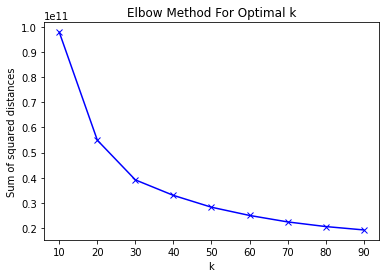

In [ ]:
final_df = pd.read_pickle('/content/drive/My Drive/Datasets/ubr_clusters.pkl')
df = final_df.drop('user_id', axis=1)
#for col in df.columns: 
#    print(col) 
#print(df.head())
Sum_of_squared_distances = []
K = range(10,100,10)

for k in K:
    print("now is executing with k = " + str(k))
    km = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=1)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
print(type(final_df['Reviews c0'][0]))

<class 'numpy.int64'>


In [ ]:
flag = np.uint64(0)
for i in range(0,90):
    #print('Reviews c'+str(i))
    for j in range(0, 1):
        if final_df['Stars c'+str(i)][j] != flag:
            print(final_df['Stars c'+str(i)][j])

In [ ]:
final_df.to_pickle(FOLDER+"/users/CompleteUsersDF")

Finally, this analysis is an example of how to show the distribution of the users involved in the business categories. As involved we inted users which has left at least one reviwes on a certaint business that is part of a given category.


In [ ]:
final_df = pd.read_pickle('/content/drive/My Drive/Datasets/ubr_clusters.pkl');
df = final_df.drop('user_id', axis=1)



In [ ]:
flag = np.uint64(0)
stop = 0

#create a new dictionary
mDictionary = {}
for i in range(90):
    mDictionary[str(i)]= 0;
print("there are ",len(df.values)," values on dataset");
#14 are the number of colums in the dataframe before Reviews columns start
#position number 15 corresponds to head of df table 'Revies c0'
i =0;
for cluster in range(0,89):
    print('cluster no. >',cluster, ' ... ');
    userWithZeroComments = 0;
    for row in df.values: #row of the table corresponds to user
        numberOfReviews = row[15+cluster];
        if numberOfReviews > 0:
            counter = mDictionary[str(cluster)];  
            mDictionary[str(cluster)] = counter + 1;    
        else :
            userWithZeroComments = userWithZeroComments+1 ;
    print('...completed');
    
    



there are  1000000  values on dataset
cluster no. > 0  ... 
...completed
...number of user with 0 comments on cluster0 is 872586
cluster no. > 1  ... 
...completed
...number of user with 0 comments on cluster1 is 917286
cluster no. > 2  ... 
...completed
...number of user with 0 comments on cluster2 is 0
cluster no. > 3  ... 
...completed
...number of user with 0 comments on cluster3 is 941998
cluster no. > 4  ... 
...completed
...number of user with 0 comments on cluster4 is 985661
cluster no. > 5  ... 
...completed
...number of user with 0 comments on cluster5 is 988315
cluster no. > 6  ... 
...completed
...number of user with 0 comments on cluster6 is 933697
cluster no. > 7  ... 
...completed
...number of user with 0 comments on cluster7 is 895214
cluster no. > 8  ... 
...completed
...number of user with 0 comments on cluster8 is 965453
cluster no. > 9  ... 
...completed
...number of user with 0 comments on cluster9 is 988396
cluster no. > 10  ... 
...completed
...number of user wit

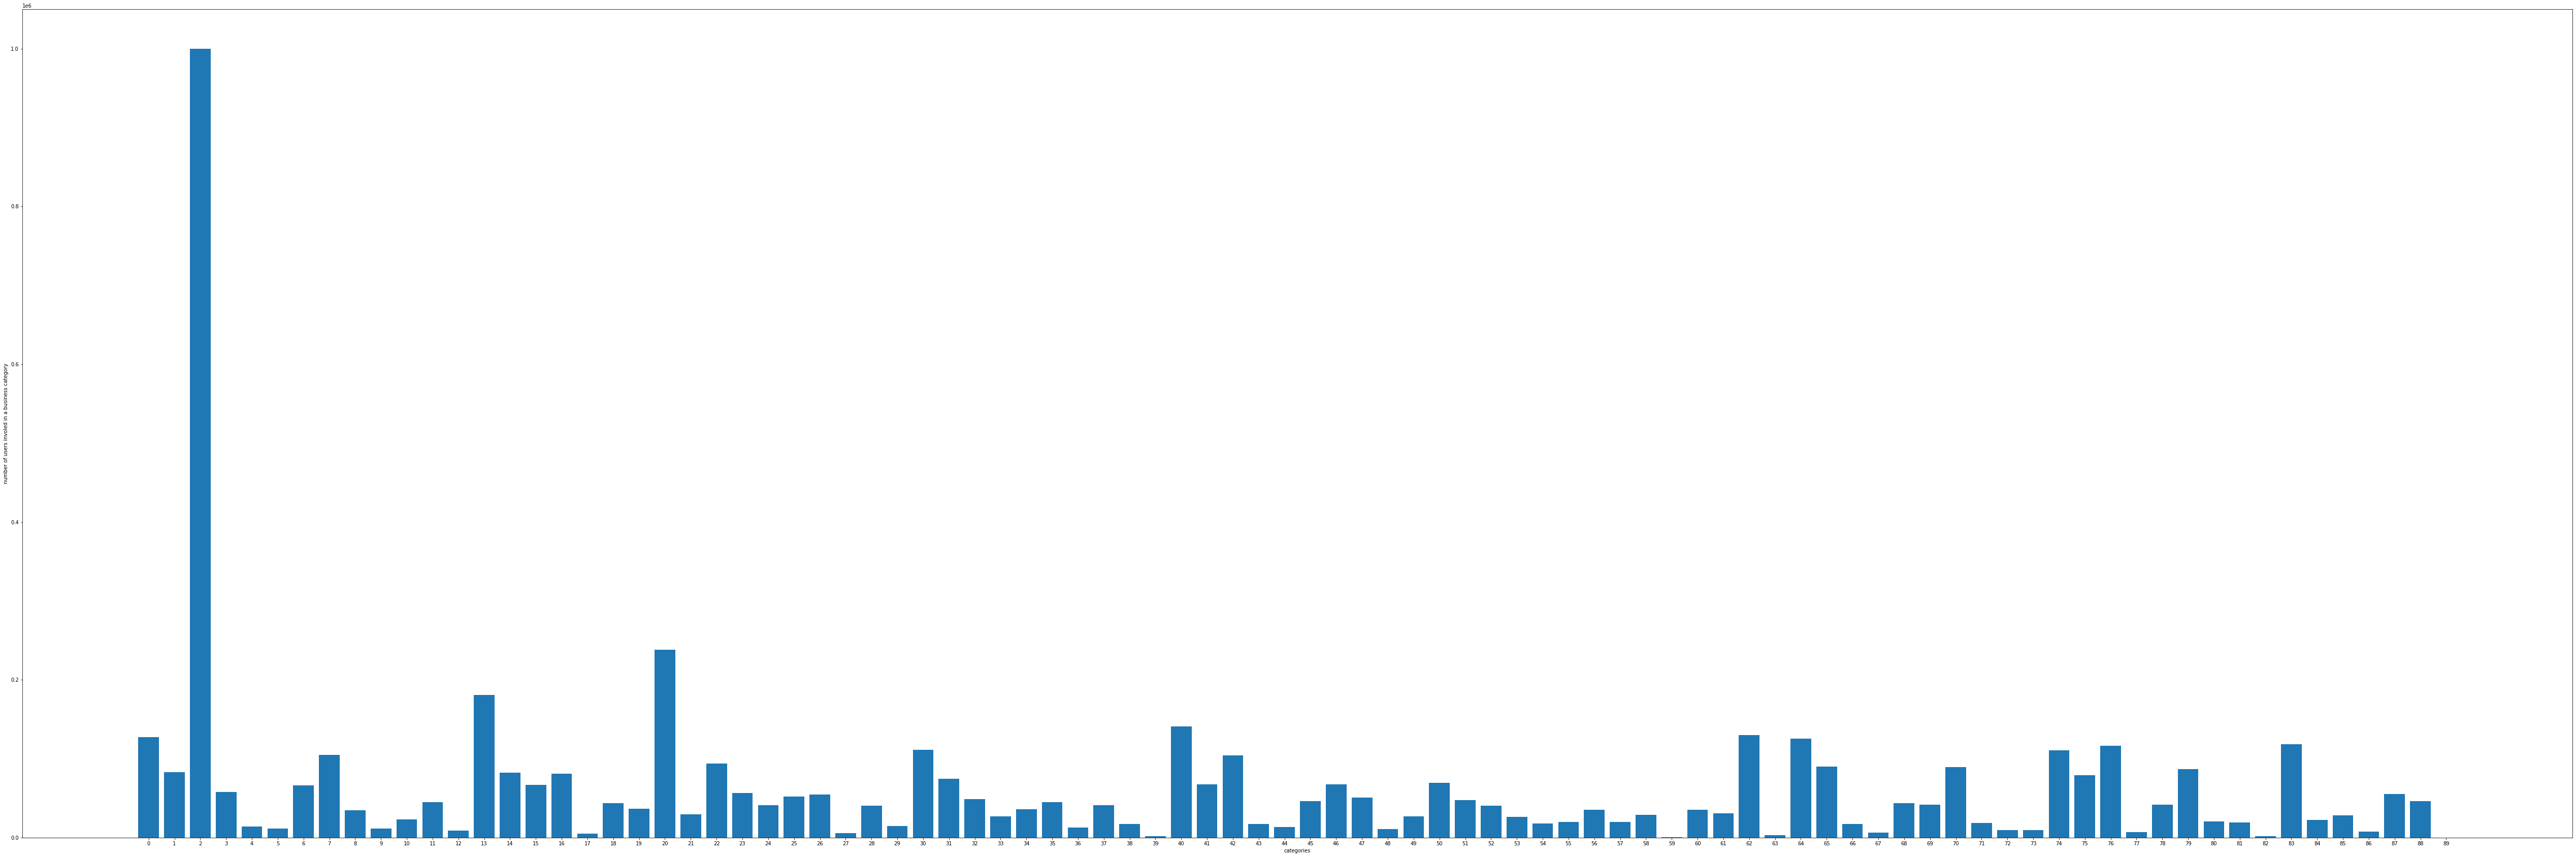

In [ ]:
#Function to bar plot a dictionary
def plot_dict(dict, metric_name):
  label = dict.keys()
  rng = range(len(label))
  plt.xticks(rng, label)
  p = plt.bar(rng, dict.values(), 0.8)
  plt.ylabel(metric_name)
  plt.xlabel('categories')
  plt.rcParams["figure.figsize"] = (90,30)
  plt.show()


plot_dict(mDictionary, 'number of users involed in a business category')